In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
from pycaret.clustering import *
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Supermarket Data (1).csv')

In [ ]:
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [ ]:
# Add WK_DAY = Shopping on Monday - Friday (SHOP_WEEKDAY = 2 - 6)
df['WK_DAY'] = np.where(np.logical_and(df['SHOP_WEEKDAY'] >= 2,df['SHOP_WEEKDAY'] <= 6),1,0)

# Add WK_END = Shopping on Saturday - Sunday (SHOP_WEEKDAY = 7, 1)
df['WK_END'] = np.where(np.logical_or(df['SHOP_WEEKDAY'] == 1,df['SHOP_WEEKDAY'] == 7),1,0)

# Add Hour_Day = Shopping on 6.00 - 18.00
df['HOUR_DAY'] = np.where(np.logical_and(df['SHOP_HOUR'] >= 6,df['SHOP_HOUR'] <= 18),1,0)

# Add Hour_Night = Shopping on 6.00 - 18.00
df['HOUR_NIGHT'] = np.where(np.logical_or(df['SHOP_HOUR'] < 6,df['SHOP_HOUR'] > 18),1,0)

df.tail(5)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION,WK_DAY,WK_END,HOUR_DAY,HOUR_NIGHT
231034,200619,2006-07-03,2,14,1,4.01,PRD0902041,CL00013,DEP00004,G00003,D00001,CUST0000669757,UM,OT,994101300586774,M,UM,Small Shop,Fresh,STORE00001,LS,E02,1,0,1,0
231035,200617,2006-06-25,1,21,1,1.96,PRD0902041,CL00013,DEP00004,G00003,D00001,NaN,NaN,NaN,994101100022598,L,MM,Full Shop,Mixed,STORE00001,LS,E02,0,1,0,1
231036,200713,2007-05-22,3,13,1,1.95,PRD0902041,CL00013,DEP00004,G00003,D00001,CUST0000472158,MM,YF,994105900483990,L,LA,Full Shop,Grocery,STORE00001,LS,E02,1,0,1,0
231037,200648,2007-01-27,7,13,1,1.97,PRD0902041,CL00013,DEP00004,G00003,D00001,CUST0000420363,MM,OT,994104200423284,M,LA,Top Up,Mixed,STORE00001,LS,E02,0,1,1,0
231038,200813,2008-05-24,7,17,1,1.94,PRD0902041,CL00013,DEP00004,G00003,D00001,CUST0000986734,LA,NaN,994111100809319,M,LA,Top Up,Mixed,STORE00,NaN,NaN,0,1,1,0


In [ ]:
df_csv = df_groupby = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(TotalSpend=('SPEND', 'sum'),
                                                                                  TotalVisits=('BASKET_ID', 'nunique'),
                                                                                  TotalSKUs=('PROD_CODE', 'nunique'),
                                                                                  FirstDate=('SHOP_DATE', 'min'),
                                                                                  LastDate=('SHOP_DATE', 'max'),
                                                                                  WkDay=('WK_DAY','sum'),
                                                                                  WkEnd=('WK_END','sum'),
                                                                                  ShopDay=('HOUR_DAY','sum'),
                                                                                  ShopNight=('HOUR_NIGHT','sum')
                                                                                  ).reset_index()

In [ ]:
##calculate ticket size
df_csv['TicketSize'] = df_csv['TotalSpend']/df_csv['TotalVisits']

max_date = df_csv['LastDate'].max()

df_csv['total_days'] = (df_csv['LastDate'] - df_csv['FirstDate']).dt.days + 1

df_csv['recency'] = (max_date - df_csv['LastDate']).dt.days

df_csv['WkDay%'] = (df_csv['WkDay'])/(df_csv['WkDay'] + df_csv['WkEnd'])

df_csv['ShopDay%'] = (df_csv['ShopDay'])/(df_csv['ShopDay'] + df_csv['ShopNight'])

In [ ]:
df_csv.head(10)

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,WkDay,WkEnd,ShopDay,ShopNight,TicketSize,total_days,recency,WkDay%,ShopDay%
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,0,1,1,0,2.440000,1,547,0.000000,1.000000
1,CUST0000000689,126.77,16,53,2007-07-22,2008-06-23,71,17,35,53,7.923125,338,13,0.806818,0.397727
2,CUST0000000998,0.84,1,1,2006-05-04,2006-05-04,1,0,1,0,0.840000,1,794,1.000000,1.000000
3,CUST0000001163,12.60,4,12,2006-10-22,2008-06-22,1,12,13,0,3.150000,610,14,0.076923,1.000000
4,CUST0000001194,1004.44,95,163,2006-04-22,2008-06-20,325,114,258,181,10.573053,791,16,0.740319,0.587699
5,CUST0000002257,1.99,1,1,2006-07-21,2006-07-21,1,0,1,0,1.990000,1,716,1.000000,1.000000
6,CUST0000002605,1.80,6,1,2006-10-08,2008-06-12,4,2,5,1,0.300000,614,24,0.666667,0.833333
7,CUST0000002637,54.51,15,22,2006-08-03,2008-05-30,24,13,31,6,3.634000,667,37,0.648649,0.837838
8,CUST0000002638,1.57,1,1,2007-04-14,2007-04-14,0,1,1,0,1.570000,1,449,0.000000,1.000000
9,CUST0000002813,58.65,12,32,2007-07-31,2008-04-12,34,15,18,31,4.887500,257,85,0.693878,0.367347


In [ ]:
exp_clu = setup(data=df_csv, ignore_features=['CUST_CODE','FirstDate', 'LastDate','WkDay','WkEnd','ShopDay','ShopNight'], normalize=True)

,Description,Value
0,session_id,8687
1,Original Data,"(2978, 15)"
2,Missing Values,False
3,Numeric Features,8
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(2978, 8)"
9,CPU Jobs,-1


In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0754,93.4804,3.1286,0,0,0


In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'green', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'green', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
kmeans,0.318900,1142.992400,1.153900,0,0,0
sc,0.251500,67.297200,1.050100,0,0,0
birch,0.231500,669.596700,1.147000,0,0,0
hclust,0.190300,795.117400,1.429700,0,0,0
ap,0.000000,0.000000,0.000000,0,0,0
kmodes,-0.075400,93.480400,3.128600,0,0,0
dbscan,-0.275700,71.190500,1.678400,0,0,0


In [ ]:
sc = create_model('sc')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2515,67.2972,1.0501,0,0,0


In [ ]:
plot_model(sc)

In [ ]:
kmeans = create_model('kmeans')

print(kmeans)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3189,1142.9924,1.1539,0,0,0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=8687, tol=0.0001, verbose=0)


In [ ]:
plot_model(kmeans)

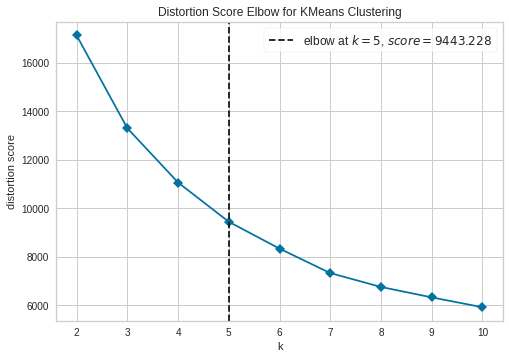

In [ ]:
plot_model(kmeans, plot = 'elbow')

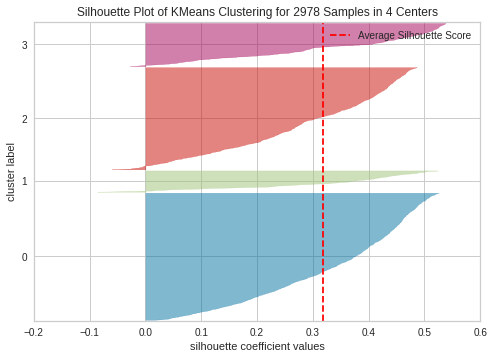

In [ ]:
plot_model(kmeans, plot = 'silhouette')

## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [ ]:
kmeans_results = assign_model(kmeans)
kmeans_results.head(5)

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,WkDay,WkEnd,ShopDay,ShopNight,TicketSize,total_days,recency,WkDay%,ShopDay%,Cluster
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,0,1,1,0,2.440000,1,547,0.000000,1.000000,Cluster 3
1,CUST0000000689,126.77,16,53,2007-07-22,2008-06-23,71,17,35,53,7.923125,338,13,0.806818,0.397727,Cluster 0
2,CUST0000000998,0.84,1,1,2006-05-04,2006-05-04,1,0,1,0,0.840000,1,794,1.000000,1.000000,Cluster 2
3,CUST0000001163,12.60,4,12,2006-10-22,2008-06-22,1,12,13,0,3.150000,610,14,0.076923,1.000000,Cluster 0
4,CUST0000001194,1004.44,95,163,2006-04-22,2008-06-20,325,114,258,181,10.573053,791,16,0.740319,0.587699,Cluster 1


In [ ]:
def class_convert(cl):
    if cl == 'Cluster 0':
        return 0
    if cl == 'Cluster 1':
        return 1
    if cl == 'Cluster 2':
        return 2
    if cl == 'Cluster 3':
        return 3

kmeans_results['Cluster'] = kmeans_results['Cluster'].apply(class_convert)

In [ ]:
kmeans_results.head(5)

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,WkDay,WkEnd,ShopDay,ShopNight,TicketSize,total_days,recency,WkDay%,ShopDay%,Cluster
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,0,1,1,0,2.440000,1,547,0.000000,1.000000,3
1,CUST0000000689,126.77,16,53,2007-07-22,2008-06-23,71,17,35,53,7.923125,338,13,0.806818,0.397727,0
2,CUST0000000998,0.84,1,1,2006-05-04,2006-05-04,1,0,1,0,0.840000,1,794,1.000000,1.000000,2
3,CUST0000001163,12.60,4,12,2006-10-22,2008-06-22,1,12,13,0,3.150000,610,14,0.076923,1.000000,0
4,CUST0000001194,1004.44,95,163,2006-04-22,2008-06-20,325,114,258,181,10.573053,791,16,0.740319,0.587699,1


In [ ]:
#Decision Tree

from sklearn import tree

X = kmeans_results[['TotalSpend','TotalVisits','TicketSize','recency','WkDay%','ShopDay%']]
print(X.head())

y = kmeans_results[['Cluster']]
print(y.head())

   TotalSpend  TotalVisits  TicketSize  recency    WkDay%  ShopDay%
0        2.44            1    2.440000      547  0.000000  1.000000
1      126.77           16    7.923125       13  0.806818  0.397727
2        0.84            1    0.840000      794  1.000000  1.000000
3       12.60            4    3.150000       14  0.076923  1.000000
4     1004.44           95   10.573053       16  0.740319  0.587699
   Cluster
0        3
1        0
2        2
3        0
4        1


In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X, y)

In [ ]:
import graphviz 

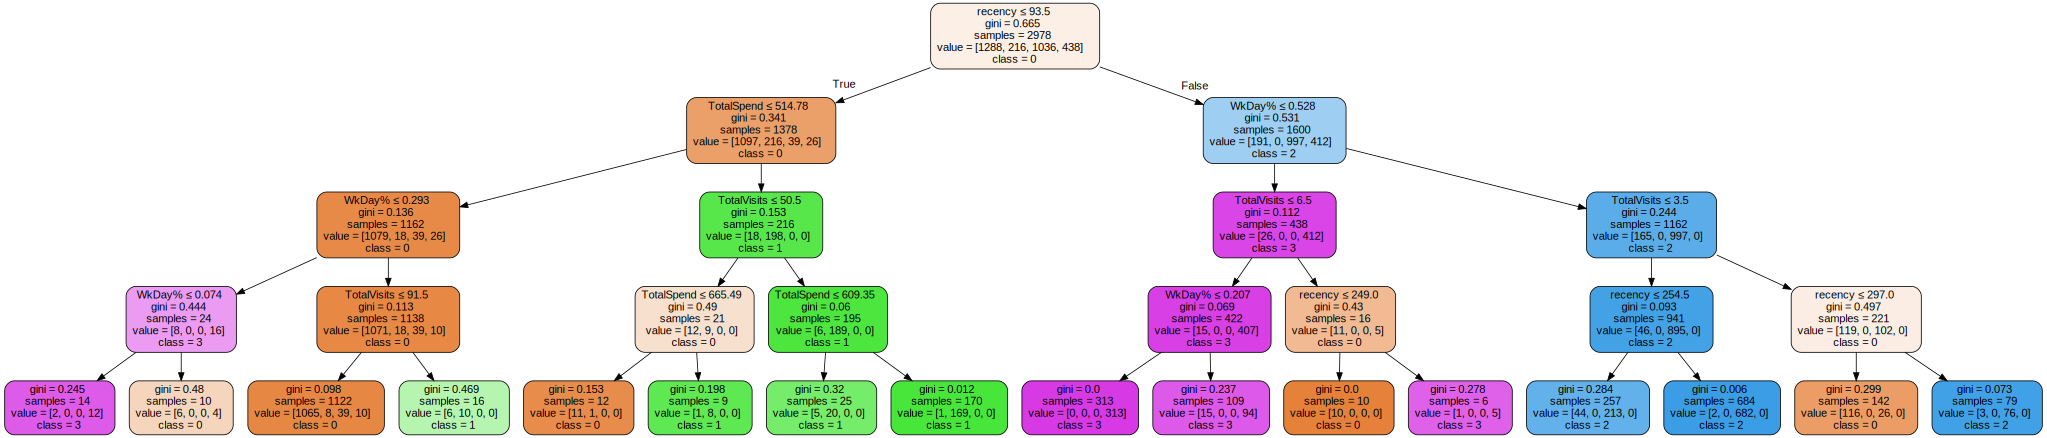

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                # feature_names=['TotalSpend','TotalVisits','TotalSKUs','TicketSize','recency','WkDay%','ShopDay%'],
                                feature_names=['TotalSpend','TotalVisits','TicketSize','recency','WkDay%','ShopDay%'],
                                class_names='0123',
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph   

In [ ]:
# Total Distribution
plot_model(kmeans, plot = 'distribution',scale = 0.5)

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'TotalSpend')

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'recency')

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'TicketSize')

In [ ]:
plot_model(kmeans, plot = 'distribution',feature = 'ShopDay%')